In [1]:
%load_ext autoreload
% autoreload 2
from dnn import pipeline
import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model

/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def has_data(null_value, threshold):
    def fn(x):
        nulls = tf.equal(x, null_value)
        null_freq = tf.reduce_mean(tf.cast(nulls, tf.float32))
        return null_freq < threshold
    return fn

In [3]:
img_width = 64
batch_size = 32
tiff_files = ["data/tif/2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tif"]
n_bands = 7
fields = ["b%d"%(i+1) for i in range(n_bands)]
dataset = (
    tf.data.Dataset.from_generator(
        pipeline.read_tiff_gen(tiff_files, img_width),
        tf.int16,
        (img_width, img_width, n_bands)
    )
    .filter(has_data(0, 0.3))
    .apply(tf.contrib.data.shuffle_and_repeat(100))
    .apply(batch_and_drop_remainder(batch_size))
)

In [4]:
img = dataset.make_one_shot_iterator().get_next()
img = tf.cast(img, tf.float32)

## Variational Autoencoder

In [79]:
n_layers = 3
base = 32

x = inp = Input(shape=[img_width, img_width, len(fields)], batch_size=batch_size)

# x = Conv2D(base, 1, activation="relu", padding="same")(x)

for i in range(n_layers):
    dim = base * 2 ** i
    x = Conv2D(dim, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(dim, 2, 2, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

mn = Conv2D(dim, 1, name="latent_mean")(x)
# Interpret as log variance because output can be negative and var >= 0
# Initialize to zero for numeric stability, also so variance is 1
lv = Conv2D(dim, 1, name="latent_log_var", kernel_initializer="zeros")(x)
sample = x = Lambda(
    lambda arg:  arg[0] + tf.random_normal(arg[0].shape) * tf.exp(arg[1] * 0.5),
    name="latent_sample"
)([mn, lv])

for i in range(n_layers):
    dim = base * 2 ** (n_layers - 1 - i)
    x = Conv2D(dim, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(dim, 2, 2, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

decoded = Conv2D(n_bands, 1, name="reconstructed")(x)

vae = Model(inp, [mn, lv, sample, decoded])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (32, 64, 64, 7)      0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (32, 64, 64, 32)     2048        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 64, 64, 32)     128         conv2d_105[0][0]                 
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (32, 32, 32, 32)     4128        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_norm

In [80]:
mn, lv, enc, dec = vae(img)

In [90]:
p = tf.placeholder(tf.float32, [64, 64, 7])

In [92]:
a = tf.unstack(p, axis=-1)[0]

In [103]:
y, _ = tf.unique(tf.reshape(a, [-1]))

In [117]:
def unique_fraction(x, threshold ):
    uniq, _ = tf.unique(tf.reshape(x, [-1]))
    return tf.size(uniq) / tf.size(x) > threshold

In [118]:
mostly_data(a, .5)

<tf.Tensor 'Greater_9:0' shape=() dtype=bool>

In [121]:
tf.reduce_any([unique_fraction(band) > threshold for band in tf.unstack(img, axis=-1)])

<tf.Tensor 'Any:0' shape=() dtype=bool>

In [113]:
tf.size

<function tensorflow.python.ops.array_ops.size(input, name=None, out_type=tf.int32)>

In [81]:
kl = -0.5 * tf.reduce_sum(1 + lv - mn**2 - tf.exp(lv))
mse = tf.reduce_mean((img - dec) ** 2)

loss = mse + kl
train_op = tf.train.AdamOptimizer().minimize(loss)

In [83]:
steps = 5000
summary_every = 25

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for s in range(steps):
        if s % summary_every == 0:
            _, mse_, kl_ = sess.run([train_op, mse, kl])
            print(f"step:%4d\tmse:%10.1f\tkl:%12.1f"%(s, mse_, kl_))
        else:
            sess.run(train_op)

step:   0	mse:15266065.0	kl:11556933632.0


KeyboardInterrupt: 

In [74]:
mn, lv, enc, dec = vae(img)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    foo = sess.run([mn, lv, enc, dec, img])

In [75]:
_, _, _, dec, y = foo

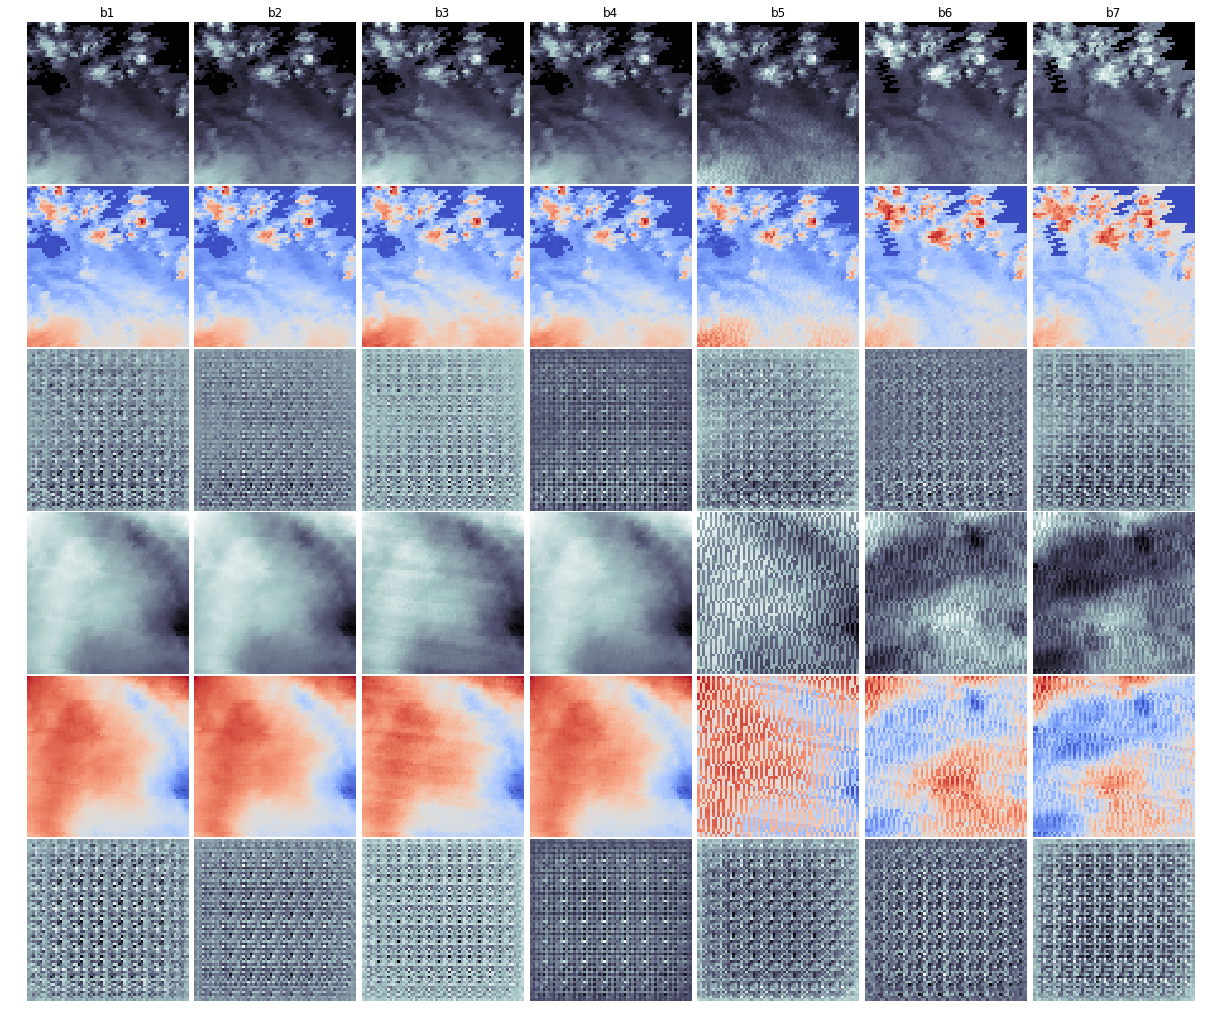

In [76]:
samples = 2
width = 3
fig, ax = plt.subplots(
    nrows=samples * 3,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width * 3)
)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for s in range(samples):
    for c, field in enumerate(fields):
        orig = ax[s * 3, c]
        orig.imshow(y[s,:,:, c], cmap="bone")
        if s == 0: orig.set_title(field)
        
        diff = ax[s * 3 + 1, c]
        diff.imshow(y[s,:,:, c] - dec[s, :, :, c], cmap="coolwarm")
            
        out = ax[s * 3 + 2, c]
        out.imshow(dec[s, :, :, c], cmap="bone")
for a in ax.flatten():
    a.set_axis_off()